This program is the base case of a image enhancer. Using a CNN autoencoder. 

In [114]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Input

import matplotlib.pyplot as plt

In [140]:
# Using the Fashion MNIST dataset to train and test the network

# Loads the dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [116]:
# Prints the max and min value of the first entity in the dataset
print('Max value in the x_train is', x_train[0].max())
print('Min value in the x_train is', x_train[0].min())
print('Shape of train dataset ', x_train.shape )
print('Shape of test dataset ', x_test.shape)

Max value in the x_train is 255
Min value in the x_train is 0
Shape of train dataset  (60000, 28, 28)
Shape of test dataset  (10000, 28, 28)


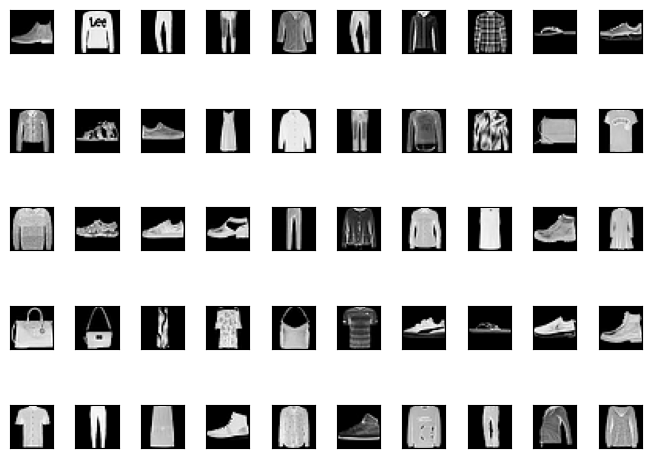

In [117]:
# plots the first 50 images of the test dataset 
fig, axs = plt.subplots(5, 10) 
fig.tight_layout(pad=-1)
plt.gray()
a = 0 
for i in range(5): 
  for j in range(10): 
    # axs[i, j].imshow(tf.squeeze(x_test[a]))     # tf.squeeze() removes dimensions of size 1 from the tensor 
    axs[i, j].imshow(x_test[a])
    axs[i, j].xaxis.set_visible(False) 
    axs[i, j].yaxis.set_visible(False) 
    a = a + 1 

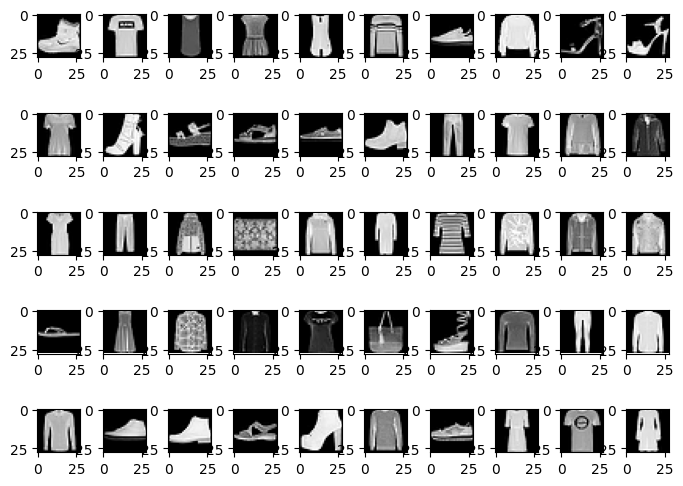

In [118]:
# plots the first 50 images of the train dataset 
fig, axs = plt.subplots(5, 10) 
fig.tight_layout(pad=-1)
plt.gray()
a = 0 
for i in range(5): 
  for j in range(10): 
    axs[i, j].imshow(tf.squeeze(x_train[a]))  
    axs[i, j].xaxis.set_visible(True) 
    axs[i, j].yaxis.set_visible(True) 
    a = a + 1 

In [119]:
# Since images are in RGB format there is the need for a normalization to a range between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [120]:
# Adds a fourth dimension with one value indicating a grayscale format of the images
x_train = x_train[..., tf.newaxis]          # <--- In case of colored images the fourth dimension needs four values -> How to implement?
x_test = x_test[...,tf.newaxis]

In [121]:
print('New shape of train dataset ', x_train.shape)
print('New shape of test dataset ', x_test.shape)

New shape of train dataset  (60000, 28, 28, 1)
New shape of test dataset  (10000, 28, 28, 1)


In [122]:
# create noisy images in order to train the network
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)  #<-- why don't use a standard normal in the frist place`?`
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)     # since in the next step values below 0 and above 1 are clipped to 0 and 1 
                                                                                # => Introduction of bias?

In [123]:
# Since values are beyond border of 0 and 1, which are necessary for grayscale, all values below 0 and above 1 are clipped respectively
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.) 
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

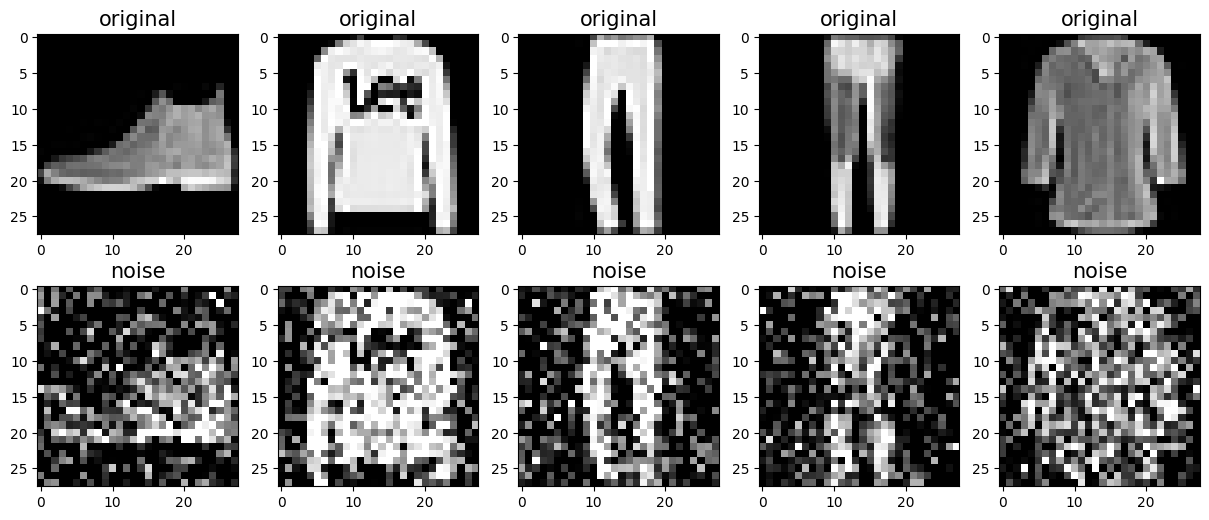

In [124]:
# Plot original and noisy images
n = 5
plt.figure(figsize=(15, 6))
plt.gray()
for i in range(n):
  ax = plt.subplot(2, n, i + 1) 
  plt.title("original", size=15) 
  plt.imshow(tf.squeeze(x_test[i])) 
  plt.gray() 
  bx = plt.subplot(2, n, n+ i + 1) 
  plt.title("noise", size=15) 
  plt.imshow(tf.squeeze(x_test_noisy[i])) 
plt.show()

In [167]:
# create the model 
# no explanation of hyperparameters
class NoiseReducer(tf.keras.Model): 
  def __init__(self):

    super(NoiseReducer, self).__init__() 

    self.encoder = tf.keras.Sequential([ 
      Input(shape=(28, 28, 3)), 
      Conv2D(16, (3,3), activation='relu', padding='same', strides=2), 
      Conv2D(8, (3,3), activation='relu', padding='same', strides=2)]) 
    
    self.decoder = tf.keras.Sequential([ 
      Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'), 
      Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'), 
      Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])                  #<-- no explanation for this layer
  
  def call(self, x): 
    encoded = self.encoder(x) 
    decoded = self.decoder(encoded) 
    return decoded

In [169]:
# Call of model object
autoencoder = NoiseReducer()

In [170]:
# Set the optimizer and loss function
autoencoder.compile(optimizer='adam', loss='mse')

In [171]:
# Trains the model in 10 epochs, also tests it 
autoencoder.fit(x_train_noisy, 
                x_train, 
                epochs=10, 
                shuffle=True, 
                validation_data=(x_test_noisy, x_test))

Epoch 1/10


ValueError: in user code:

    File "C:\Users\Win10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Win10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Win10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Win10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Win10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Win10\AppData\Local\Temp\__autograph_generated_file85wxm544.py", line 10, in tf__call
        encoded = ag__.converted_call(ag__.ld(self).encoder, (ag__.ld(x),), None, fscope)

    ValueError: Exception encountered when calling layer 'noise_reducer_2' (type NoiseReducer).
    
    in user code:
    
        File "C:\Users\Win10\AppData\Local\Temp\ipykernel_17988\3338918253.py", line 19, in call  *
            encoded = self.encoder(x)
        File "C:\Users\Win10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\Win10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\engine\input_spec.py", line 280, in assert_input_compatibility
            raise ValueError(
    
        ValueError: Exception encountered when calling layer 'sequential_4' (type Sequential).
        
        Input 0 of layer "conv2d_6" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (32, 28, 28, 1)
        
        Call arguments received by layer 'sequential_4' (type Sequential):
          • inputs=tf.Tensor(shape=(32, 28, 28, 1), dtype=float32)
          • training=True
          • mask=None
    
    
    Call arguments received by layer 'noise_reducer_2' (type NoiseReducer):
      • x=tf.Tensor(shape=(32, 28, 28, 1), dtype=float32)


In [145]:
# importing PIL
from PIL import Image
import numpy as np

import cv2

In [146]:
img_height = 28
img_width = 28

img_data_array = []

In [142]:
# Image import for Denoising
# Read image
image = Image.open('Noisy Image.png')                              #<-- one possibility to load images in python

# image= cv2.imread( 'Noisy Image.png', cv2.COLOR_BGR2RGB)
image= cv2.imread( 'Noisy Image.png', cv2.COLOR_BGR2GRAY)           #<-- another possibility to load images in python
# image=cv2.resize(image, (img_height, img_width),interpolation = cv2.INTER_AREA)
#image=cv2.resize(image, (img_height, img_width))

# Resizes image to 28 x 28 
image = np.resize(image, (img_height, img_width, 1))                #<-- here one can add a third dimension to the image which contains multiple values

# Converts image to float value 
image = image.astype('float32') 

# Normalizes image; Needed for neural network
image /= 255.

# image = image[..., tf.newaxis]          # <--- In case of colored images the fourth dimension needs four values -> How to implement? => Use resize

In [168]:

# Now that the model object 'autoencoder' is trained it can be applied to images that is has never seen before
# Since currently there are separates images, it is applied to x_test_noisy

# Model gets the new images to encode/ familiarize with them
# encoded_imgs = autoencoder.encoder(image).numpy()        #<-- this is the point where other images can be used to enhance
                                                                # Prerequisite: Grayscale 28 x 28 images

encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()

# Model enhances quality of images by using encoded images over the latent space
decoded_imgs = autoencoder.decoder(encoded_imgs)

ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 28, 28, 1), found shape=(28, 28, 3)

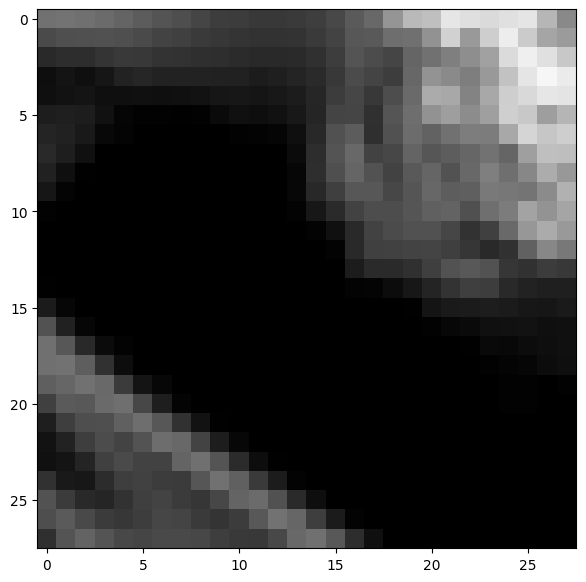

In [165]:
n = 10 
plt.figure(figsize=(20, 7))
# plt.gray()

plt.imshow(image) 

plt.show()

In [ ]:
# plot all images for comparison
n = 10 
plt.figure(figsize=(20, 7))
plt.gray()
for i in range(n): 
  # display original + noise 
  bx = plt.subplot(3, n, i + 1) 
  plt.title("original + noise") 
  plt.imshow(tf.squeeze(x_test_noisy[i])) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 
  
  # display reconstruction 
  cx = plt.subplot(3, n, i + n + 1) 
  plt.title("reconstructed") 
  plt.imshow(tf.squeeze(decoded_imgs[i])) 
  bx.get_xaxis().set_visible(False) 
  bx.get_yaxis().set_visible(False) 
  print("Dimension of reconstructed images ", decoded_imgs[i].shape)
  
  # display original 
  ax = plt.subplot(3, n, i + 2*n + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(x_test[i])) 
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 
  print("Dimensions of original images ", x_test_noisy[i].shape)

plt.show()